In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy import interpolate
import json

In [2]:
normal_pc = np.load("../../data/WADI/normal_pc4.npy")
anomaly_pc = np.load("../../data/WADI/anomaly_pc4.npy")

In [3]:
def interp_1darray(data):
    assert len(data.shape)==1, "data is not 1d"
    num_index = [i for i in range(len(data)) if not np.isnan(data[i])]
    f= interpolate.interp1d(num_index, data[num_index])
    data_new = f(range(len(data)))
    return data_new
    
def interp_2darray(data):
    assert len(data.shape)==2," data is not 2d "
    new_data = data.copy().T
    for i in range(len(new_data)):
        if(np.sum(np.isnan(new_data[i]))>0):
            new_data[i] = interp_1darray(new_data[i])
    new_data = new_data.T
    return new_data
    
def normalize_1d(data):
    new_data = data.copy()
    min_ = min(new_data)
    max_ = max(new_data)
    if(max_-min_==0):
        new_data = np.ones(new_data.shape,dtype="double") 
    #print(data)
    else:
        new_data= (new_data-min_)/(max_-min_)
    #print(data)
    return new_data

def normalize_2d(data, axis = 1):
    new_data = data.copy()
    if(axis == 0):
        new_data = new_data.T
    #print(data.shape)
    for i in range(len(new_data)):
        new_data[i] = normalize_1d(new_data[i])
    if(axis == 0):
        new_data = new_data.T
        
    return new_data

In [4]:
normal_len = len(normal_pc)
anomaly_len = len(anomaly_pc)
dimension = normal_pc.shape[1]
sample_size = 30

# Train
train_sample_step = 20
train_size = (normal_len-sample_size)//train_sample_step
print("train_sample_step: ", train_sample_step, ", train_size: ", train_size)

train_x = np.zeros((train_size, sample_size, dimension), dtype="double")
for i in range(train_size):
    train_x[i, :, :] = normal_pc\
    [i*train_sample_step: (i*train_sample_step+sample_size), :]
train_y = np.zeros((train_size, sample_size*dimension), dtype = "double")
for i in range(train_size):
    train_y[i] = train_x[i,:,:].ravel()

train_sample_step:  20 , train_size:  60478


In [5]:
test_sample_step=2
test_size = (anomaly_len-sample_size)//test_sample_step
print("test_sample_step: ", test_sample_step)
test_index = np.array([i*test_sample_step for i in range(test_size)])
test_x = np.zeros((test_size, sample_size, dimension), dtype = "double")
for i in range(test_size):
    test_x[i,:,:] = anomaly_pc[test_index[i]:(test_index[i]+sample_size), :-1]
test_y = np.zeros((test_size, sample_size*dimension), dtype = "double")
for i in range(test_size):
    test_y[i] = test_x[i,:,:].ravel()
test_attack_level = np.array([np.mean(anomaly_pc\
                                      [i:(i+sample_size), -1]) for i in test_index])

test_sample_step:  2


In [6]:
def get_eval(ground_truth, pred_val):
    assert ground_truth.shape == pred_val.shape
    TP, FP, TN, FN = 0,0,0,0
    gth = ground_truth.ravel()
    pred = pred_val.ravel()
    for i in range(len(gth)):
        if(gth[i] >0.5):
            if(pred[i]>0.5):
                TP+=1
            elif(pred[i]<=0.5):
                FN +=1
        elif(gth[i]<=0.5):
            if(pred[i]>0.5):
                FP +=1
            elif(pred[i]<=0.5):
                TN+=1
    if(TP==0 or FP==0 or FN==0):
        #print("someone=0, TP=", TP, " FP=", FP, ", FN=",FN)
        return (0,0,0)
    pre = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    
def get_pred_errors(model, test_x, test_y):
    test_pred = model.predict(test_x)
    return np.array([mean_squared_error(test_y[i], test_pred[i]) for i in range(len(test_y))])
def eval_model(errors, attack_levels, th_int=0.1, attack_th=0.3):
    err_normalized = normalize_1d(errors)
    thresholds = np.arange(0.5*th_int,1,th_int)
    print("corr: ", np.corrcoef(err_normalized, attack_levels))
    attack_th = np.array([1 if i>attack_th else 0 for i in attack_levels])
    
    normal_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==0])
    anomaly_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==1])
    print("normal_err: ", pd.Series(normal_err).describe())
    print("anomaly_err:", pd.Series(anomaly_err).describe())
    
    
    res = {"th":np.zeros((len(thresholds))),"pre":np.zeros((len(thresholds))), "rec":np.zeros((len(thresholds))), "F1":np.zeros((len(thresholds)))}
    for i in range(len(thresholds)):
        th = thresholds[i]
        #print("Threshold = ", th)
        err_thd = np.array([1 if i >th else 0 for i in err_normalized])
        pre, rec, F1=get_eval(attack_th, err_thd)
        res["th"][i]=th
        res["pre"][i]=pre
        res["rec"][i] = rec
        res["F1"][i] = F1
    plt.subplot(1,3,1)
    plt.plot(thresholds, res["pre"])
    plt.xlabel("threshold")
    plt.ylabel("pre")
    plt.title("pre")
    
    plt.subplot(1,3,2)
    plt.plot(thresholds, res["rec"])
    plt.xlabel("threshold")
    plt.ylabel("rec")
    plt.title("rec")
    
    plt.subplot(1,3,3)
    plt.plot(thresholds, res["F1"])
    plt.xlabel("threshold")
    plt.ylabel("F1")
    plt.title("F1")
    return res

In [7]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model3.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model3.fit(train_x, train_y, epochs=5)

#res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
#print(max(res["F1"])) 

data_dim: 1200
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60478/60478 [==============================] - 26s 433us/sample - loss: 0.0972 - mean_squared_error: 0.0972
Epoch 2/5
60478/60478 [==============================] - 24s 402us/sample - loss: 0.0970 - mean_squared_error: 0.0970
Epoch 3/5
60478/60478 [==============================] - 25s 411us/sample - loss: 0.0970 - mean_squared_error: 0.0970
Epoch 4/5
60478/60478 [==============================] - 26s 432us/sample - loss: 0.0970 - mean_squared_error: 0.0970
Epoch 5/5
60478/60478 [==============================] - 24s 396us/sample - loss: 0.0970 - mean_squared_error: 0.0970


In [29]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

# change the output layer to relu
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.relu)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model1.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model1.fit(train_x, train_y, epochs=5)

#res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
#print(max(res["F1"])) 

data_dim: 1200
Epoch 1/5
60478/60478 [==============================] - 23s 388us/sample - loss: 0.0638 - mean_squared_error: 0.0638
Epoch 2/5
60478/60478 [==============================] - 22s 366us/sample - loss: 0.0608 - mean_squared_error: 0.0608- loss: 0.0609 - mean_squared_error:  - ETA
Epoch 3/5
60478/60478 [==============================] - 23s 380us/sample - loss: 0.0597 - mean_squared_error: 0.0597- l
Epoch 4/5
60478/60478 [==============================] - 24s 398us/sample - loss: 0.0592 - mean_squared_error: 0.0592
Epoch 5/5
60478/60478 [==============================] - 26s 428us/sample - loss: 0.0585 - mean_squared_error: 0.0585


In [30]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

# change the output layer to softmax, add linear output 
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax), 
    tf.keras.layers.Dense(sample_size*dimension)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model2.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model2.fit(train_x, train_y, epochs=5)

#res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
#print(max(res["F1"])) 

data_dim: 1200
Epoch 1/5
60478/60478 [==============================] - 67s 1ms/sample - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 2/5
60478/60478 [==============================] - 68s 1ms/sample - loss: 0.0453 - mean_squared_error: 0.0453
Epoch 3/5
60478/60478 [==============================] - 67s 1ms/sample - loss: 0.0415 - mean_squared_error: 0.0415
Epoch 4/5
60478/60478 [==============================] - 67s 1ms/sample - loss: 0.0353 - mean_squared_error: 0.0353
Epoch 5/5
60478/60478 [==============================] - 68s 1ms/sample - loss: 0.0306 - mean_squared_error: 0.0306


In [8]:
pred_y = model3.predict(test_x)
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (pred_y.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =pred_y[vis_num+j*rec_step].reshape(sample_size,dimension)

In [ ]:
plt.figure(figsize=(20,10*normal_pc.shape[1]))
x_=np.arange(anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(x_, anomaly_pc[:,i],color="b")
    plt.plot(x_, pred_y_data[:,i], color ="r")
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(x_, np.abs(anomaly_pc[:,i]-pred_y_data[:,i]))

corr:  [[1.         0.32015775]
 [0.32015775 1.        ]]
normal_err:  count    81140.000000
mean         0.173673
std          0.129782
min          0.000000
25%          0.079485
50%          0.139347
75%          0.220002
max          1.000000
dtype: float64
anomaly_err: count    5245.000000
mean        0.364527
std         0.204623
min         0.074301
25%         0.207142
50%         0.353180
75%         0.478971
max         0.943271
dtype: float64
0.3237929318068691


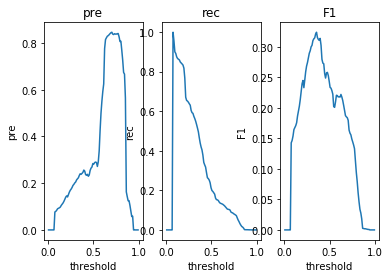

In [13]:
res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
print(max(res["F1"])) 

In [ ]:
pred_y = model1.predict(test_x)
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (pred_y.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =pred_y[vis_num+j*rec_step].reshape(sample_size,dimension)
plt.figure(figsize=(20,10*normal_pc.shape[1]))
x_=np.arange(anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(x_, anomaly_pc[:,i],color="b")
    plt.plot(x_, pred_y_data[:,i], color ="r")
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(x_, np.abs(anomaly_pc[:,i]-pred_y_data[:,i]))

In [ ]:
pred_y = model2.predict(test_x)
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (pred_y.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =pred_y[vis_num+j*rec_step].reshape(sample_size,dimension)
plt.figure(figsize=(20,10*normal_pc.shape[1]))
x_=np.arange(anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(x_, anomaly_pc[:,i],color="b")
    plt.plot(x_, pred_y_data[:,i], color ="r")
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(x_, np.abs(anomaly_pc[:,i]-pred_y_data[:,i]))

In [ ]:
model2.fit(train_x, train_y, epochs=5)
pred_y = model2.predict(test_x)
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (pred_y.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =pred_y[vis_num+j*rec_step].reshape(sample_size,dimension)
plt.figure(figsize=(20,10*normal_pc.shape[1]))
x_=np.arange(anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(x_, anomaly_pc[:,i],color="b")
    plt.plot(x_, pred_y_data[:,i], color ="r")
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(x_, np.abs(anomaly_pc[:,i]-pred_y_data[:,i]))

In [ ]:
pred_y = model2.predict(test_x)
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (pred_y.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =pred_y[vis_num+j*rec_step].reshape(sample_size,dimension)
plt.figure(figsize=(20,10*normal_pc.shape[1]))
x_=np.arange(anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(x_, anomaly_pc[:,i],color="b")
    plt.plot(x_, pred_y_data[:,i], color ="r")
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(x_, np.abs(anomaly_pc[:,i]-pred_y_data[:,i]))

In [8]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

# change the output layer to relu, add linear
model_relu_linear = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_relu_linear.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model_relu_linear.fit(train_x, train_y, epochs=5)

#res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
#print(max(res["F1"])) 

data_dim: 1200
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/5
60478/60478 [==============================] - 15s 255us/sample - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 2/5
60478/60478 [==============================] - 15s 251us/sample - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/5
60478/60478 [==============================] - 15s 249us/sample - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/5
60478/60478 [==============================] - 15s 251us/sample - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 5/5
60478/60478 [==============================] - 15s 249us/sample - loss: 0.0020 - mean_squared_error: 0.0020


corr:  [[1.         0.43014813]
 [0.43014813 1.        ]]
normal_err:  count    81140.000000
mean         0.029371
std          0.031294
min          0.000580
25%          0.011498
50%          0.020002
75%          0.035395
max          0.617886
dtype: float64
anomaly_err: count    5245.000000
mean        0.142986
std         0.197024
min         0.000000
25%         0.029115
50%         0.055330
75%         0.147822
max         1.000000
dtype: float64
0.40038999025024374


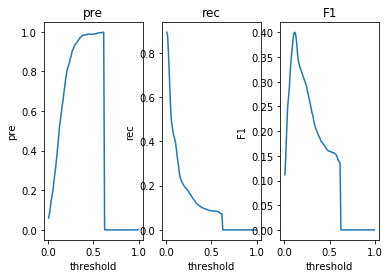

In [36]:
res = eval_model(get_pred_errors(model_relu_linear, test_x, test_y), test_attack_level, th_int=0.01)
print(max(res["F1"])) 

0.3951603430048161

In [7]:
model_relu_linear.fit(train_x, train_y, epochs=5)
pred_y = model_relu_linear.predict(test_x)
# prepare to visualize the predicted values
vis_nums = [0]
rec_step = sample_size//test_sample_step
pred_y_data = np.zeros((anomaly_pc.shape[0], anomaly_pc.shape[1]-1))
for vis_num in vis_nums:
    max_j = np.min(((anomaly_pc.shape[0]-vis_num*test_sample_step)//sample_size, (pred_y.shape[0]-vis_num)//rec_step))
    for j in range(max_j):
        #if(vis_num+j)
        pred_y_data[(vis_num*test_sample_step + j*sample_size):(vis_num*test_sample_step+(j+1)*sample_size),:] \
            =pred_y[vis_num+j*rec_step].reshape(sample_size,dimension)
plt.figure(figsize=(20,10*normal_pc.shape[1]))
x_=np.arange(anomaly_pc.shape[0])
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(x_, anomaly_pc[:,i],color="b")
    plt.plot(x_, pred_y_data[:,i], color ="r")
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(x_, np.abs(anomaly_pc[:,i]-pred_y_data[:,i]))

NameError: name 'model_relu_linear' is not defined

corr:  [[1.         0.42994264]
 [0.42994264 1.        ]]
normal_err:  count    81140.000000
mean         0.028469
std          0.031855
min          0.000000
25%          0.011325
50%          0.018495
75%          0.032788
max          0.729593
dtype: float64
anomaly_err: count    5245.000000
mean        0.134981
std         0.177023
min         0.001742
25%         0.030551
50%         0.057636
75%         0.163474
max         1.000000
dtype: float64
0.3946188340807175


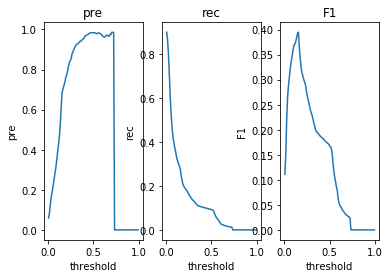

In [49]:
res = eval_model(get_pred_errors(model_relu_linear, test_x, test_y), test_attack_level, th_int=0.01)
print(max(res["F1"])) 


In [10]:
start = []
end = []
for i in range(anomaly_pc.shape[0]-1):
    if(anomaly_pc[i][-1]==0 and anomaly_pc[i+1][-1]==1):
        #print("0->1", i, i+1)
        start.append(i+1)
    elif(anomaly_pc[i][-1]==1 and anomaly_pc[i+1][-1]==0):
        #print("1->0", i, i+1)
        end.append(i+1)

attack_ = np.concatenate((start, end)).reshape(2, len(start)).transpose(1,0)

In [ ]:
plt.figure(figsize=(20,10*normal_pc.shape[1]))

range2 = np.arange(55000,67000)
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(range2, anomaly_pc[range2,:][:,i],color="b")
    plt.plot(range2, pred_y_data[range2,:][:,i], color ="g")
    for j in range(len(start)):
        if(start[j] in range2 or end[j] in range2):
            plt.axvspan(start[j], end[j], alpha=0.3, color='red')
    plt.title("pc"+str(i))
            
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(range2, np.abs(anomaly_pc[range2,:][:,i]-pred_y_data[range2,:][:,i]))
    for j in range(len(start)):
        if(start[j] in range2 or end[j] in range2):
            plt.axvspan(start[j], end[j], alpha=0.3, color='red')
    plt.title("pc"+str(i))

In [ ]:
plt.figure(figsize=(20,10*normal_pc.shape[1]))

range2 = np.arange(68000,80000)
for i in range(normal_pc.shape[1]):
    plt.subplot(normal_pc.shape[1], 2, 2*i+1)
    plt.plot(range2, anomaly_pc[range2,:][:,i],color="b")
    plt.plot(range2, pred_y_data[range2,:][:,i], color ="g")
    for j in range(len(start)):
        if(start[j] in range2 or end[j] in range2):
            plt.axvspan(start[j], end[j], alpha=0.3, color='red')
    plt.title("pc"+str(i))
            
    plt.subplot(normal_pc.shape[1], 2, 2*i+2)
    plt.plot(range2, np.abs(anomaly_pc[range2,:][:,i]-pred_y_data[range2,:][:,i]))
    for j in range(len(start)):
        if(start[j] in range2 or end[j] in range2):
            plt.axvspan(start[j], end[j], alpha=0.3, color='red')
    plt.title("pc"+str(i))